In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# import plotly.express as px
from scipy.integrate import solve_ivp 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import string
import networkx as nx

In [2]:
# Number of individuals in the community
N = 10000

# Number of communities and edges added per epoch
M = 51

# Start and End epochs
t0, tf = 0, 3000

# Number of timesteps
Nt = 3000

# Time series
t = np.linspace(t0, tf, Nt + 1)

# Differential equation params
sigma = 0.1
a0 = 0.01
a1 = 0.0001
gamma = 0.07
zeta = 0.02
chi = 0.1

# Setup for the beta slider
beta_min = 0
beta_max = 0.06

beta_steps = M - 1

# Coupling strength steps
epsilon_steps = M - 1

# Patch steps
l_steps = M - 1

# The randomisation for exposed population will be upto max_exposed
max_exposed = 1000

# Generating all the lists
epsilon_list = np.logspace(-5, 1, epsilon_steps, base=10)
l_list = np.arange(1, M)
beta_list = np.linspace(beta_min, beta_max, beta_steps)
custom_E0 = np.random.randint(1, max_exposed, size=(M,1))

In [3]:
# Making a complete graph with 4 Nodes
adj_mat = np.full((M, M), 1, dtype="int").reshape(M, M)
# graph = nx.erdos_renyi_graph(M, 0.05, seed=None, directed=False)
# adj_mat = nx.to_numpy_array(graph).reshape(M, M)

# Making the degree list for each node (di = M-1 here)
degree_list = np.sum(adj_mat, axis=0).reshape(M, 1)

# Dividing the adjacency matrix by rowsum
row_sums= np.sum(adj_mat, axis=1)
adj_mat_normalised = (adj_mat/row_sums[:,np.newaxis]).reshape(M, M)

In [4]:
def get_degree_counts(n : int, adj_mat):
    freq_map = np.zeros(n) # degree -> count
    for i in range(n):
        num_neighbours = int(np.sum(adj_mat[i]))
        freq_map[num_neighbours] += 1
    return np.array(freq_map)

In [5]:
# Returns a uniform probability distribution
def const_prob(adj_mat, patches_to_apply):
    m = int(len(adj_mat)) # Number of communities

    # each node as probability as 1/patches_to_apply
    retval = np.full(m, 1, dtype="float") / float(patches_to_apply)

    # Replace with zero in the range [patches_to_apply, len(adj_list))
    np.put(retval, np.arange(patches_to_apply, M), 0)

    return retval

In [6]:
# Returns node wise distribution strategy for test kits
def g_val(a1, K, prob_distri_test_kit):
    return a1 * K * prob_distri_test_kit

In [7]:
def migration_term(adj_mat, adj_mat_normalised, compartment):
    # Getting the Amn x Sm term
    retval = np.dot(adj_mat_normalised, compartment).reshape(int(len(compartment)), 1)
    
    # Returning the migration amount
    return (retval - compartment)

In [8]:
def ODE_multi_node_with_testkit(t, X_flat, beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, a1):
    # Unraveling the X_flat vector
    X = X_flat.reshape(shape_X) 
    S, E, I, H, R, K = X
    
    # Reshaping into patchesx1 matrix from rank-1 array
    S = S.reshape(num_patches, 1)
    E = E.reshape(num_patches, 1)
    I = I.reshape(num_patches, 1)
    H = H.reshape(num_patches, 1)
    R = R.reshape(num_patches, 1)
    
    # Warning : K is a number NOT a list
    # So, we will turn it into a "fake" list by repeating it num_patches times
    K = K.reshape(num_patches, 1)
    
    # We are using degree centrality based test kit distribution
    g = g_val(a1, K[0], const_prob(adj_mat, l).reshape(num_patches, 1))

    # Reshaping into num_patches x 1 matrix
    g = g.reshape(num_patches, 1)
    
    # Obtaining the total population of each patch
    tot_pop = S + E + I + H + R
    
    # Hospitalization param
    alpha = a0 + g
    
    S_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, S)).reshape(num_patches, 1)
    E_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, E)).reshape(num_patches, 1)
    I_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, I)).reshape(num_patches, 1)
    R_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, R)).reshape(num_patches, 1)
    
    # Find the derivatives list, broadcasting coming in clutch now
    dSdt = (np.divide(-(beta * S * I), tot_pop)) +  S_migration
    dEdt = (np.divide((beta * S * I), tot_pop)) - (sigma * E) + E_migration
    dIdt = (sigma * E) -  (alpha * I) + I_migration
    dHdt = (alpha * I) - (gamma * H)
    dRdt = (gamma * H) + R_migration
    dKdt = (zeta * np.full(num_patches, np.sum(I)).reshape(num_patches, 1)) - (chi * K)
    
    # Reshape the derivatives list for good measure
    dSdt = dSdt.reshape(num_patches, 1)
    dEdt = dEdt.reshape(num_patches, 1)
    dIdt = dIdt.reshape(num_patches, 1)
    dHdt = dHdt.reshape(num_patches, 1)
    dRdt = dRdt.reshape(num_patches, 1)
    dKdt = dKdt.reshape(num_patches, 1)
        
    derivs =  np.array([dSdt, dEdt, dIdt, dHdt, dRdt, dKdt])
    
    return derivs.ravel()

def ODE_multi_node_without_testkit(t, X_flat, beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, a1):
    return ODE_multi_node_with_testkit(t, X_flat, beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, 0)

In [9]:
def solver(adj_mat, adj_mat_normalised, degree_list, M, beta, ODE_func, E0, epsilon, num_patches, l):
    # Initial conditions for given beta
    I0, H0, R0, K0 = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)

    # Mandatory reshaping, for safety
    E0 = E0.reshape(M, 1)
    I0 = I0.reshape(M, 1)
    H0 = H0.reshape(M, 1)
    R0 = R0.reshape(M, 1)
    K0 = K0.reshape(M, 1)
    
    # Getting the susceptibles
    # [TBX : This makes N*M susceptibles by broadcasting]
    Total_population = np.full(M, N).reshape(M, 1)
    S0 = Total_population - E0 - I0 - H0 - R0
    S0 = S0.reshape(M, 1)

    # Making the state vector
    X0 = np.array([S0, E0, I0, H0, R0, K0])

    # Ravel the X vector temporarily
    shape_X = X0.shape
    X_flat = X0.ravel()

    # Solving the initial value problem
    solved_ivp = solve_ivp(ODE_func, (t0, tf), X_flat, args=(beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, a1), t_eval=t)

    # Returning the raw solved ivp data for plotting
    # solved_ivp.y.reshape(6, M, Nt+1)
    return solved_ivp

In [10]:
# X, Y with testkits
x_with_testkits = np.array([])
y_with_testkits = np.array([])

# X, Y without testkits
x_without_testkits = np.array([])
y_without_testkits = np.array([])

# RMSE will be stored here
RMSE_total=[]
RMSE_test_kits=[]
RMSE_wo_test_kits=[]

# Initial condition
# custom_E0 = np.random.randint(1,1000, size=(M,1))
    
for l_value in l_list:
    for epsilon_value in epsilon_list:

        # Solving the IVP using our solver function
        solved_ivp = solver(adj_mat, adj_mat_normalised, degree_list, M, 0.03, ODE_multi_node_with_testkit, custom_E0, epsilon_value, M, l_value)

        # Getting the y value reshaped
        jffy = solved_ivp.y.reshape(6, M, Nt+1)

        # Obtaining the Infection values for each communities
        infection = jffy[2]
        infection = infection / N

        # Total Synch Error---------------------------------------------------
        rmse_tot= np.mean(
                    np.sqrt(
                        np.mean(
                            (infection-np.mean(infection,axis=0).reshape(1,Nt+1))**2,axis=0).reshape(1,Nt+1)))
        
        RMSE_total.append(rmse_tot)
        
        # Cluster Synchronisation error --------------------------------------
        # ------------------------------------------------------ with test kit
        test_kit_nodes=infection[:l_value]
        rmse_test_kit= np.mean(
                        np.sqrt(
                            np.mean(
                                (test_kit_nodes-np.mean(test_kit_nodes,axis=0).reshape(1,Nt+1))**2,axis=0).reshape(1,Nt+1)))

        RMSE_test_kits.append(rmse_test_kit)

        # Cluster Synchronisation error --------------------------------------
        # --------------------------------------------------- without test kit  
        non_test_kit_nodes=infection[l_value:]
        rmse_wo_test_kits= np.mean(
                        np.sqrt(
                            np.mean(
                                (non_test_kit_nodes-np.mean(non_test_kit_nodes,axis=0).reshape(1,Nt+1))**2,axis=0).reshape(1,Nt+1)))

        RMSE_wo_test_kits.append(rmse_wo_test_kits)

In [11]:
RMSE_totalnp = np.array(RMSE_total)
RMSE_test_kitsnp=np.array(RMSE_test_kits)
RMSE_wo_test_kitsnp=np.array(RMSE_wo_test_kits)

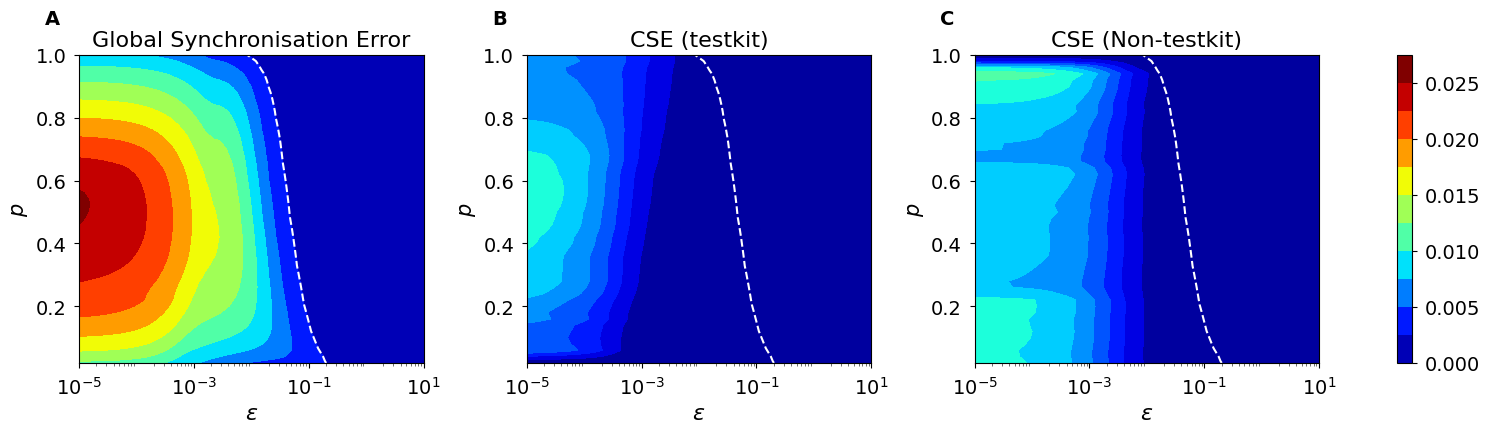

In [12]:
with plt.style.context('seaborn-paper'):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
    plt.subplots_adjust(wspace = 0.3)
    
    # Font sizes for everything
    fs_title = 16
    fs_labels = 16
    fs_legend = 10
    fs_ticks = 14
    lw_size = 3
    
    X, Y = np.meshgrid(epsilon_list, l_list)

    max_val = max([np.max(RMSE_totalnp), np.max(RMSE_test_kitsnp), np.max(RMSE_wo_test_kitsnp)])
    min_val = min(np.min(RMSE_totalnp), np.min(RMSE_test_kitsnp), np.min(RMSE_wo_test_kitsnp))
    
    im = axs[0].contourf(X, Y, RMSE_totalnp.reshape(M-1, epsilon_steps), 10, vmin=min_val, vmax=max_val, cmap='jet')
    axs[0].set_xscale('log')
    axs[0].set_title('Global Synchronisation Error', fontsize=fs_title)
    
    lvls = im.levels
    
    im1 = axs[0].contour(X, Y, RMSE_totalnp.reshape(M-1, epsilon_steps), levels=lvls[:2], vmin=min_val, vmax=max_val, colors='white')
    axs[0].set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)
        im1.collections[i].set_linestyle('--')
    
    im1 = axs[1].contour(X, Y, RMSE_totalnp.reshape(M-1, epsilon_steps), levels=lvls[:2], vmin=min_val, vmax=max_val, colors='white')
    axs[1].set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)
        im1.collections[i].set_linestyle('--')

    im1 = axs[1].contourf(X, Y, RMSE_test_kitsnp.reshape(M-1, epsilon_steps), 8, vmin=min_val, vmax=max_val, cmap='jet')
    axs[1].set_title('CSE (testkit)', fontsize=fs_title)
    axs[1].set_xscale('log')

    im1 = axs[2].contour(X, Y, RMSE_totalnp.reshape(M-1, epsilon_steps), levels=lvls[:2], vmin=min_val, vmax=max_val, colors='white')
    axs[2].set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)
        im1.collections[i].set_linestyle('--')
    
    im1 = axs[2].contourf(X, Y, RMSE_wo_test_kitsnp.reshape(M-1, epsilon_steps), 8, vmin=min_val, vmax=max_val, cmap='jet')
    axs[2].set_title('CSE (Non-testkit)', fontsize=fs_title)
    axs[2].set_xscale('log')

    for ax in axs.flat:
        ax.set(xlabel='$\log{\epsilon}$', ylabel='Fraction of nodes with testkits ($p$)')
        
    axs[0].set_xlabel('$\epsilon$', fontsize=fs_labels)
    axs[1].set_xlabel('$\epsilon$', fontsize=fs_labels)    
    axs[2].set_xlabel('$\epsilon$', fontsize=fs_labels)

    axs[0].set_ylabel('$p$', fontsize=fs_labels - 1)
    axs[1].set_ylabel('$p$', fontsize=fs_labels - 1)
    axs[2].set_ylabel('$p$', fontsize=fs_labels - 1)
    
    # print(X) 
    colorbar = fig.colorbar(im, ax=axs)
    colorbar.ax.tick_params(labelsize=fs_ticks)  # Set the colorbar tick font size
    
    for i in range(3):
        axs[i].text(
                    -0.1, 
                    1.1, 
                    string.ascii_uppercase[i], 
                    transform=axs[i].transAxes, 
                    size=14, 
                    weight='bold'
                )
        
    for i in range(3):
        x_ticks_labels = [r'$10^{-5}$', r'$10^{-3}$', r'$10^{-1}$', r'$10^{1}$']
        x_ticks_vals = [10**(-5), 10**(-3), 10**(-1), 10**(1)]
        
        y_ticks_vals = [10, 20, 30, 40, 50]
        y_ticks_labels = ['0.2', '0.4', '0.6', '0.8', '1.0']

        axs[i].set_xticks([float(x_tick) for x_tick in x_ticks_vals],
                         [str(x_tick) for x_tick in x_ticks_labels],
                            fontsize=fs_ticks)
        
        axs[i].set_yticks([float(y_tick) for y_tick in y_ticks_vals],
                         [str(y_tick) for y_tick in y_ticks_labels],
                            fontsize=fs_ticks)

        axs[i].set_xlim(epsilon_list[0], epsilon_list[-1])
        axs[i].set_ylim(l_list[0], l_list[-1])


    fig.savefig('rmse_p_epsilon_true_contourf.svg', dpi=1200, bbox_inches='tight')

In [13]:
RMSE_totalnp_old = RMSE_totalnp
RMSE_test_kitsnp_old = RMSE_test_kitsnp
RMSE_wo_test_kitsnp_old =RMSE_wo_test_kitsnp

# Reduced model run

In [14]:
def func(mig_array, H, K, alpha, beta, gamma, sigma, zeta, chi):
    S,E,I,R= mig_array
    N_mig_arr= np.sum(mig_array) + H

    mig_array_dot= np.array([
        -beta*S*I / N_mig_arr,
        beta*S*I / N_mig_arr - sigma*E, 
        sigma*E - alpha*I, 
        gamma*H
    ])
    
    return mig_array_dot, alpha*I-gamma*H

def ODE_for_reduced_eqns(t, X_flat, l1,l2, epsilon, beta, gamma, sigma, zeta, chi, a0, a1):
    mig_array = X_flat[0:8]
    H1= X_flat[8]
    H2=X_flat[9]
    K= X_flat[10]
    
    # Getting the 2*4 migration variables
    mig_array = mig_array.reshape(2,4)
    
    # Getting the 2 communities
    C1 = mig_array[0]
    C2 = mig_array[1]
    
    # Getting alpha for C1 and C2
    alpha_C1 = a0 + a1*K/l1
    alpha_C2 = a0
    
    # Getting derivatives
    C1_dot,H1_dot = func(C1, H1, K, alpha_C1, beta, gamma, sigma, zeta, chi) 
    C2_dot,H2_dot = func(C2, H2, K, alpha_C2, beta, gamma, sigma, zeta, chi)
    
    C1_dot = C1_dot + (l2*epsilon/(M-1))*(C2-C1)
    C2_dot = C2_dot + (l1*epsilon/(M-1))*(C1-C2)
    
    K_dot = zeta*(l1*C1[2]+l2*C2[2]) - chi*K
    
    X_dot = np.concatenate((C1_dot,C2_dot,H1_dot,H2_dot,K_dot), axis=None)
    
    return X_dot

In [15]:
testtest = [i + 1 for i in range(5)]
print(testtest)
sum_of_elements = np.mean(testtest[3:])
print(sum_of_elements)

[1, 2, 3, 4, 5]
4.5


In [16]:
RMSE_total=[]

# Initial condition
# custom_E0 = np.random.randint(1,1000, size=(M,1))

# E1 = 0
# for i in range(l_value):
#     E1 += custom_E0[i][0]

# E1

# E2 = 0
# for i in range(l_value, M):
#     E2 += custom_E0[i][0]

for l_value in l_list:
    E1 = int(np.mean(custom_E0[:l_value]))
    E2 = int(np.mean(custom_E0[l_value:]))
    for epsilon_value in epsilon_list:
        #-----------------------------------------------------
#         E1,E2= custom_E0[0][0],custom_E0[l_value][0]

        # Initial conditions for given epsilon
        X0= np.array([N-E1,E1,0,0,N-E2,E2,0,0,0,0,0])

        X_flat = X0.ravel()

        # Solving the initial value problem
        solved_ivp = solve_ivp(ODE_for_reduced_eqns, (t0, tf), X_flat, args=(l_value, M-l_value, epsilon_value,  0.03, gamma, sigma, zeta, chi, a0, a1))

        # Obtaining the Infection values for both communities
        I_1 = solved_ivp.y[2]
        I_2 = solved_ivp.y[6]

        infection= np.vstack((I_1,I_2))/N

        Nt= solved_ivp.y.shape[1]
        # Total Synch Error---------------------------------------------------
        rmse_tot= np.mean(
                    np.sqrt(
                        np.mean(
                                (infection-np.mean(infection,axis=0).reshape(1,Nt))**2,axis=0).reshape(1,Nt)))
        RMSE_total.append(rmse_tot)
        #--------------------------------------------------------

In [17]:
RMSE_totalnp1 = np.array(RMSE_total)

In [18]:
# lvls[0] -= 0.00005

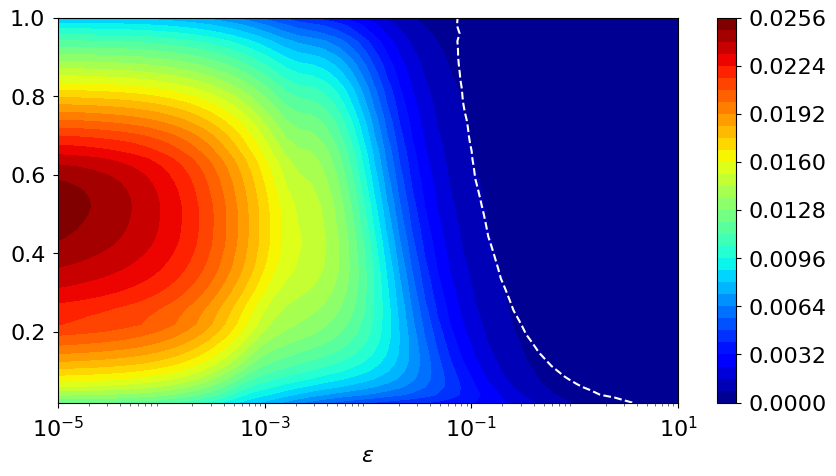

In [19]:
with plt.style.context('seaborn-paper'):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    plt.subplots_adjust(wspace = 0.3)
    
    # Font sizes for everything
    fs_title = 18
    fs_labels = 16
    fs_legend = 10
    fs_ticks = 16
    lw_size = 3
    
    X, Y = np.meshgrid(epsilon_list, l_list)
    
#     max_val = max([np.max(RMSE_totalnp1), np.max(RMSE_totalnp)])
#     min_val = min([np.min(RMSE_totalnp1), np.min(RMSE_totalnp)])

    max_val = np.max(RMSE_totalnp)
    min_val = np.min(RMSE_totalnp)

    im1 = axs.contourf(X, Y, RMSE_totalnp.reshape(M-1, epsilon_steps), levels=35, vmin=min_val, vmax=max_val, cmap='jet')
    axs.set_xscale('log')
    axs.set_xlabel('$\epsilon$', fontsize=fs_labels)
    axs.set_ylabel('', fontsize=fs_labels)
    
    # Get levels of the contourf
    lvls = im1.levels

    colorbar = fig.colorbar(im1, ax=axs)
    colorbar.ax.tick_params(labelsize=fs_ticks)  # Set the colorbar tick font size
    
    im1 = axs.contour(X, Y, RMSE_totalnp1.reshape(M-1, epsilon_steps), levels=lvls[:2], vmin=min_val, vmax=max_val, colors='white')
    axs.set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)
        im1.collections[i].set_linestyle('--')
        
    
    x_ticks_labels = [r'$10^{-5}$', r'$10^{-3}$', r'$10^{-1}$', r'$10^{1}$']
    x_ticks_vals = [10**(-5), 10**(-3), 10**(-1), 10**(1)]

    y_ticks_vals = [10, 20, 30, 40, 50]
    y_ticks_labels = ['0.2', '0.4', '0.6', '0.8', '1.0']

    axs.set_xticks([float(x_tick) for x_tick in x_ticks_vals],
                     [str(x_tick) for x_tick in x_ticks_labels],
                        fontsize=fs_ticks)

    axs.set_yticks([float(y_tick) for y_tick in y_ticks_vals],
                     [str(y_tick) for y_tick in y_ticks_labels],
                        fontsize=fs_ticks)

    axs.set_xlim(epsilon_list[0], epsilon_list[-1])
    axs.set_ylim(l_list[0], l_list[-1])


    fig.savefig('red-model-rmse-p-eps-pixelated.svg', dpi=1200, bbox_inches='tight')

In [20]:
print(im1.levels)
print(im.levels)
# for i in range(int(len(im1.collections))):
#     print(im1.collections[i])


[0.     0.0008]
[0.     0.0025 0.005  0.0075 0.01   0.0125 0.015  0.0175 0.02   0.0225
 0.025  0.0275]


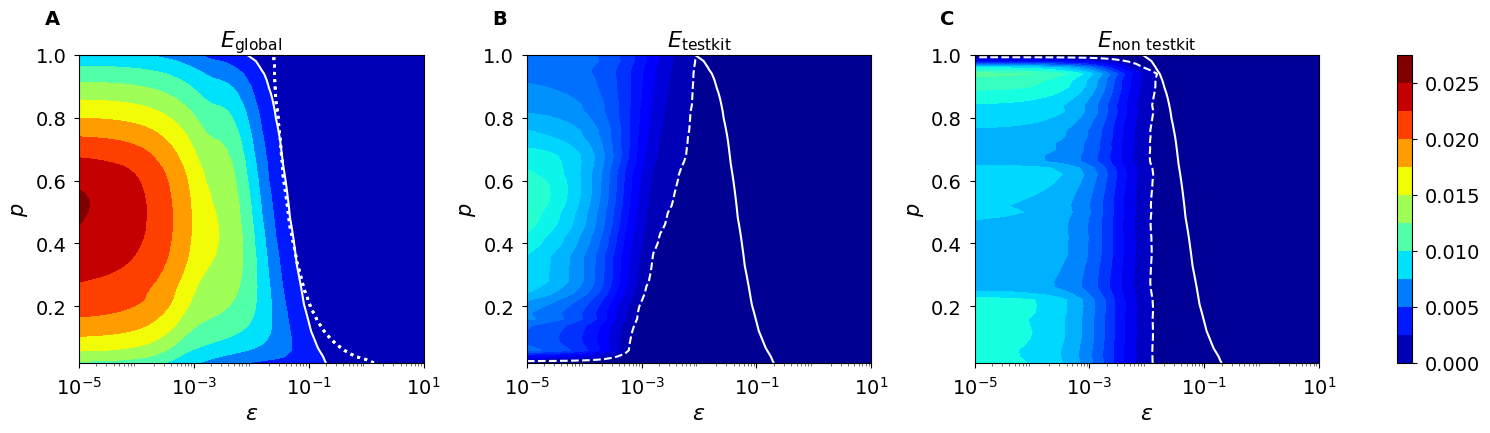

In [21]:
with plt.style.context('seaborn-paper'):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
    plt.subplots_adjust(wspace = 0.3)
    
    # Font sizes for everything
    fs_title = 16
    fs_labels = 16
    fs_legend = 10
    fs_ticks = 14
    lw_size = 3
    
    X, Y = np.meshgrid(epsilon_list, l_list)

    max_val = max([np.max(RMSE_totalnp_old), np.max(RMSE_test_kitsnp_old), np.max(RMSE_wo_test_kitsnp_old)])
    min_val = min(np.min(RMSE_totalnp_old), np.min(RMSE_test_kitsnp_old), np.min(RMSE_wo_test_kitsnp_old))
    
    im = axs[0].contourf(X, Y, RMSE_totalnp_old.reshape(M-1, epsilon_steps), 10, vmin=min_val, vmax=max_val, cmap='jet')
    axs[0].set_xscale('log')
    axs[0].set_title('$E_{\mathrm{global}}$', fontsize=fs_title)
    
    lvls = im.levels
    
    im1 = axs[0].contour(X, Y, RMSE_totalnp_old.reshape(M-1, epsilon_steps), levels=lvls[:2], vmin=min_val, vmax=max_val, colors='white')
    axs[0].set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)
#         im1.collections[i].set_linestyle('--')

    im1 = axs[1].contour(X, Y, RMSE_totalnp_old.reshape(M-1, epsilon_steps), levels=lvls[:2], vmin=min_val, vmax=max_val, colors='white')
    axs[1].set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)
        
    ###################################

    im1 = axs[1].contourf(X, Y, RMSE_test_kitsnp_old.reshape(M-1, epsilon_steps), 12, vmin=min_val, vmax=max_val, cmap='jet')
    axs[1].set_title('$E_{\mathrm{testkit}}$', fontsize=fs_title)
    axs[1].set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)

    im1 = axs[1].contour(X, Y, RMSE_test_kitsnp_old.reshape(M-1, epsilon_steps), levels=im1.levels[1:2], vmin=min_val, vmax=max_val, colors='white')
    axs[1].set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)
        im1.collections[i].set_linestyle('--')
        
    ####################################
    im1 = axs[2].contourf(X, Y, RMSE_wo_test_kitsnp_old.reshape(M-1, epsilon_steps), 12, vmin=min_val, vmax=max_val, cmap='jet')
    axs[2].set_title('$E_{\mathrm{non\ testkit}}$', fontsize=fs_title)
    axs[2].set_xscale('log')
    
    im1 = axs[2].contour(X, Y, RMSE_wo_test_kitsnp_old.reshape(M-1, epsilon_steps), levels=im1.levels[1:2], vmin=min_val, vmax=max_val, colors='white')
    axs[2].set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)
        im1.collections[i].set_linestyle('--')
 
    im1 = axs[2].contour(X, Y, RMSE_totalnp_old.reshape(M-1, epsilon_steps), levels=lvls[:2], vmin=min_val, vmax=max_val, colors='white')
    axs[2].set_xscale('log')
    
    for i in range(int(len(im1.collections))):
        im1.collections[i].set_linewidth(1.5)



    for ax in axs.flat:
        ax.set(xlabel='$\log{\epsilon}$', ylabel='Fraction of nodes with testkits ($p$)')
        
    axs[0].set_xlabel('$\epsilon$', fontsize=fs_labels)
    axs[1].set_xlabel('$\epsilon$', fontsize=fs_labels)    
    axs[2].set_xlabel('$\epsilon$', fontsize=fs_labels)

    axs[0].set_ylabel('$p$', fontsize=fs_labels - 1)
    axs[1].set_ylabel('$p$', fontsize=fs_labels - 1)
    axs[2].set_ylabel('$p$', fontsize=fs_labels - 1)
    
    # print(X) 
    colorbar = fig.colorbar(im, ax=axs)
    colorbar.ax.tick_params(labelsize=fs_ticks)  # Set the colorbar tick font size
    
    for i in range(3):
        axs[i].text(
                    -0.1, 
                    1.1, 
                    string.ascii_uppercase[i], 
                    transform=axs[i].transAxes, 
                    size=14, 
                    weight='bold'
                )
        
    for i in range(3):
        im1 = axs[0].contour(X, Y, RMSE_totalnp1.reshape(M-1, epsilon_steps), levels=lvls[:2], vmin=min_val, vmax=max_val, colors='white', linestyles='dotted', linewidths=2.0)
        
        x_ticks_labels = [r'$10^{-5}$', r'$10^{-3}$', r'$10^{-1}$', r'$10^{1}$']
        x_ticks_vals = [10**(-5), 10**(-3), 10**(-1), 10**(1)]
        
        y_ticks_vals = [10, 20, 30, 40, 50]
        y_ticks_labels = ['0.2', '0.4', '0.6', '0.8', '1.0']

        axs[i].set_xticks([float(x_tick) for x_tick in x_ticks_vals],
                         [str(x_tick) for x_tick in x_ticks_labels],
                            fontsize=fs_ticks)
        
        axs[i].set_yticks([float(y_tick) for y_tick in y_ticks_vals],
                         [str(y_tick) for y_tick in y_ticks_labels],
                            fontsize=fs_ticks)

        axs[i].set_xlim(epsilon_list[0], epsilon_list[-1])
        axs[i].set_ylim(l_list[0], l_list[-1])


    fig.savefig('rmse_p_epsilon_true_contourf.svg', dpi=1200, bbox_inches='tight')

In [22]:
print(lvls)

[0.     0.0025 0.005  0.0075 0.01   0.0125 0.015  0.0175 0.02   0.0225
 0.025  0.0275]
